In [1]:
# Resources link :  https://www.kaggle.com/code/utkarshsaxenadn/underwater-imagery-segmentation-pix2pix-gan/notebook#Data
#Imports

# Common
import os 
import keras
import numpy as np
from glob import glob   #used to search for files that match a specific file pattern or name
from tqdm import tqdm   # generation of progress bar
from numpy import zeros
import tensorflow as tf
from numpy.random import randint

# Data 
from tensorflow.image import resize
from tensorflow.keras.utils import img_to_array   # changed code
from tensorflow.keras.utils import load_img       # changed code
# Data Viz
import matplotlib.pyplot as plt

# Model
from keras.layers import ReLU
from keras.models import Model
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import concatenate
from keras.layers import ZeroPadding2D
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization   #normalizing activation vectors from hidden layers using the mean and variance of the current batch

# Callbacks 
from keras.callbacks import Callback

# Model Viz
from tensorflow.keras.utils import plot_model



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def load_image(path):
    img = load_img(path)
    img = img_to_array(img)/255.
    img = resize(img, (256,256))
    img = tf.cast(img, tf.float32) # This step is not necessary
    return img

In [3]:
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    

In [4]:
def load_images(root_path, img_format, mask_format=None, trim=None):  #  trim: removing whitespaces from a string
    
    # Collect all Image Paths
    paths = sorted(glob(root_path + f"/*.{img_format}"))
    if trim is not None:
        paths = paths[:trim]
    # Create Space for Images and Masks
    images, masks = zeros(shape=(len(paths), 256,256,3)), zeros(shape=(len(paths), 256,256,3))
    
    # Iterate through each path
    for i, path in tqdm(enumerate(paths), desc='Loading'):
        
        # Load and add to Images
        images[i] = load_image(path)
        
        # Update path for Mask path
        mask_path = path.replace('images', 'masks')
        
        if mask_format is not None:
            mask_path = mask_path.replace(img_format, mask_format)
        
        # Load and add to Masks
        masks[i] = load_image(mask_path)
    
    # Return Images and Masks
    return images, masks

In [5]:
train_path = '../input/semantic-segmentation-of-underwater-imagery-suim/train_val/images'
train_images, train_masks = load_images(train_path, img_format="jpg", mask_format='bmp', trim=1000)

Loading: 1000it [00:42, 23.56it/s]


In [6]:
def show_images(n_images=5):
    for i in range(n_images):
        
        id = randint(len(train_images))
        image, mask = train_images[id], train_masks[id]
        
        plt.figure(figsize=(10,8))
        
        plt.subplot(1,2,1)
        show_image(image)
        
        plt.subplot(1,2,2)
        show_image(mask)
        
        plt.show()

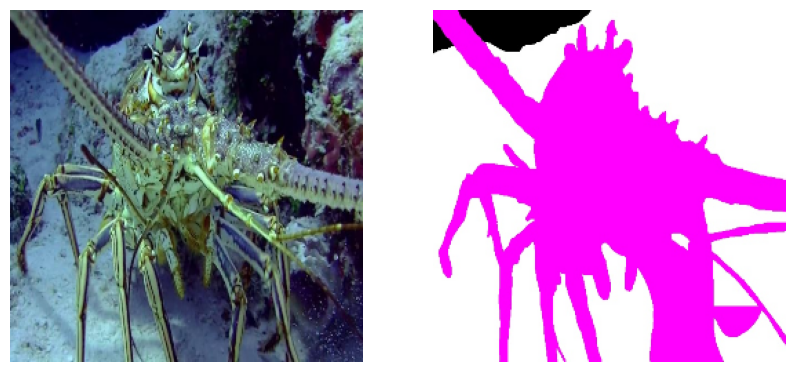

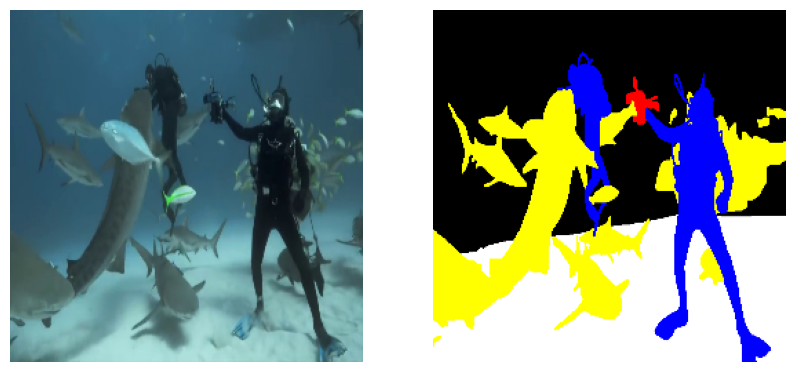

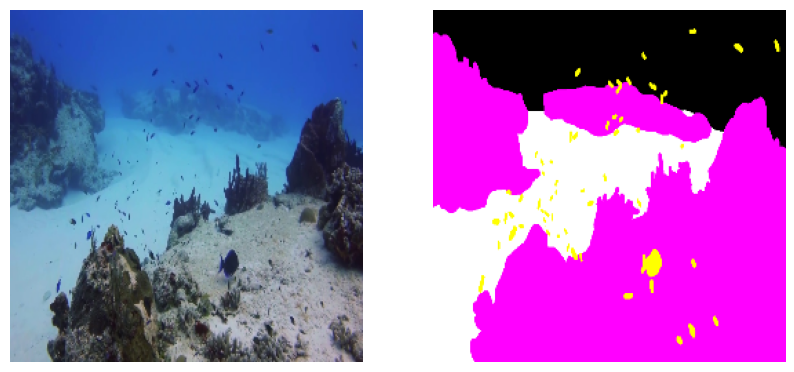

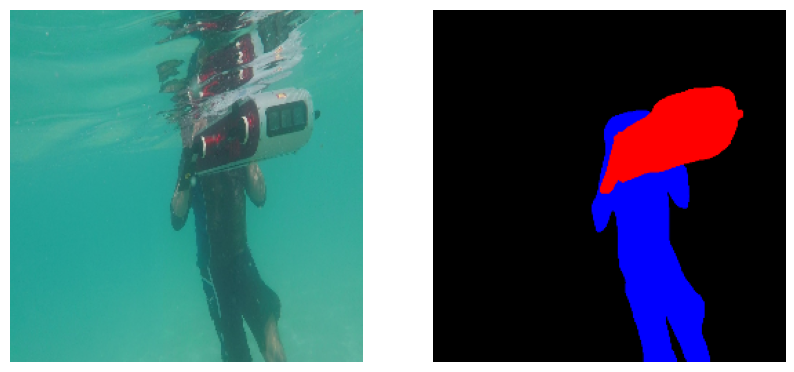

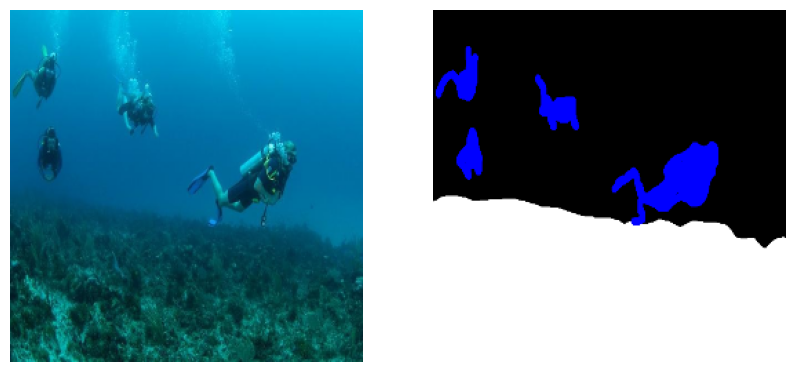

In [7]:
show_images()

In [8]:
# The Pix2Pix GAN is a general approach for image-to-image translation. It is based on the conditional generative adversarial network,
# where a target image is generated, conditional on a given input image

#What is encoder and decoder in U-Net?
#An overview of Unet architectures for semantic segmentation ...
#A U-shaped architecture consists of a specific encoder-decoder scheme: 
#The encoder reduces the spatial dimensions in every layer and increases the channels. On the other hand,
#the decoder increases the spatial dims while reducing the channels

class Encoder(Layer):
    
    def __init__(self, filters, apply_norm=True, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        
        self.filters = filters
        self.apply_norm = apply_norm
        
        self.c1 = Conv2D(filters, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')
        self.bn = BatchNormalization()
        self.act = LeakyReLU()
        
    def call(self, X):
        x = self.c1(X)
        if self.apply_norm :
            x = self.bn(x)
        x = self.act(x)
        return x
        
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "apply_norm":self.apply_norm
        }

In [9]:
class Decoder(Layer):
    
    def __init__(self, filters, apply_dropout=False, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        
        self.filters = filters
        self.apply_dropout = apply_dropout
        
        self.cT = Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')
        self.bn = BatchNormalization()
        self.drop = Dropout(0.5)
        self.act = ReLU()
        
        
    def call(self, X):
        x = self.cT(X)
        x = self.bn(x)
        if self.apply_dropout:
            x = self.drop(x)
        x = self.act(x)
        return x
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "apply_dropout":self.apply_dropout
        }

In [10]:
# Inputs
gen_input = Input(shape=(256,256,3), name="Input")

# Encoder - Downsampling Phase
c1 = Encoder(64, apply_norm=False, name="Encoder1")(gen_input)
c2 = Encoder(128, name="Encoder2")(c1)
c3 = Encoder(256, name="Encoder3")(c2)
c4 = Encoder(512, name="Encoder4")(c3)
c5 = Encoder(512, name="Encoder5")(c4)
c6 = Encoder(512, name="Encoder6")(c5)

# Encoding - Latent Representation
e = Encoder(512, name="Encoding")(c6)

#  Attention plus decoder network.
d1 = Decoder(512,apply_dropout=True,name="Decoder1")(e)
a1 = concatenate([d1, c6])

d2 = Decoder(512,apply_dropout=True,name="Decoder2")(a1)
a2 = concatenate([d2, c5])

d3 = Decoder(512,apply_dropout=True,name="Decoder3")(a2)
a3 = concatenate([d3, c4])

d4 = Decoder(512, name="Decoder4")(a3)
a4 = concatenate([d4, c3])

d5 = Decoder(256, name="Decoder5")(a4)
a5 = concatenate([d5, c2])

d6 = Decoder(128, name="Decoder6")(a5)
a6 = concatenate([d6, c1])

d7 = Decoder(64, name="Decoder7")(a6)

init = tf.random_normal_initializer(stddev=0.02)
gen_out = Conv2D(3, kernel_size=1, strides=1, padding='same', activation='tanh', kernel_initializer=init, name="gen_out")(d7)

# Model
generator = Model(
    inputs=gen_input,
    outputs=gen_out,
    name="Generator"
)

# Compiling
generator.compile(
    loss='binary_crossentropy',
    optimizer='adam'
)

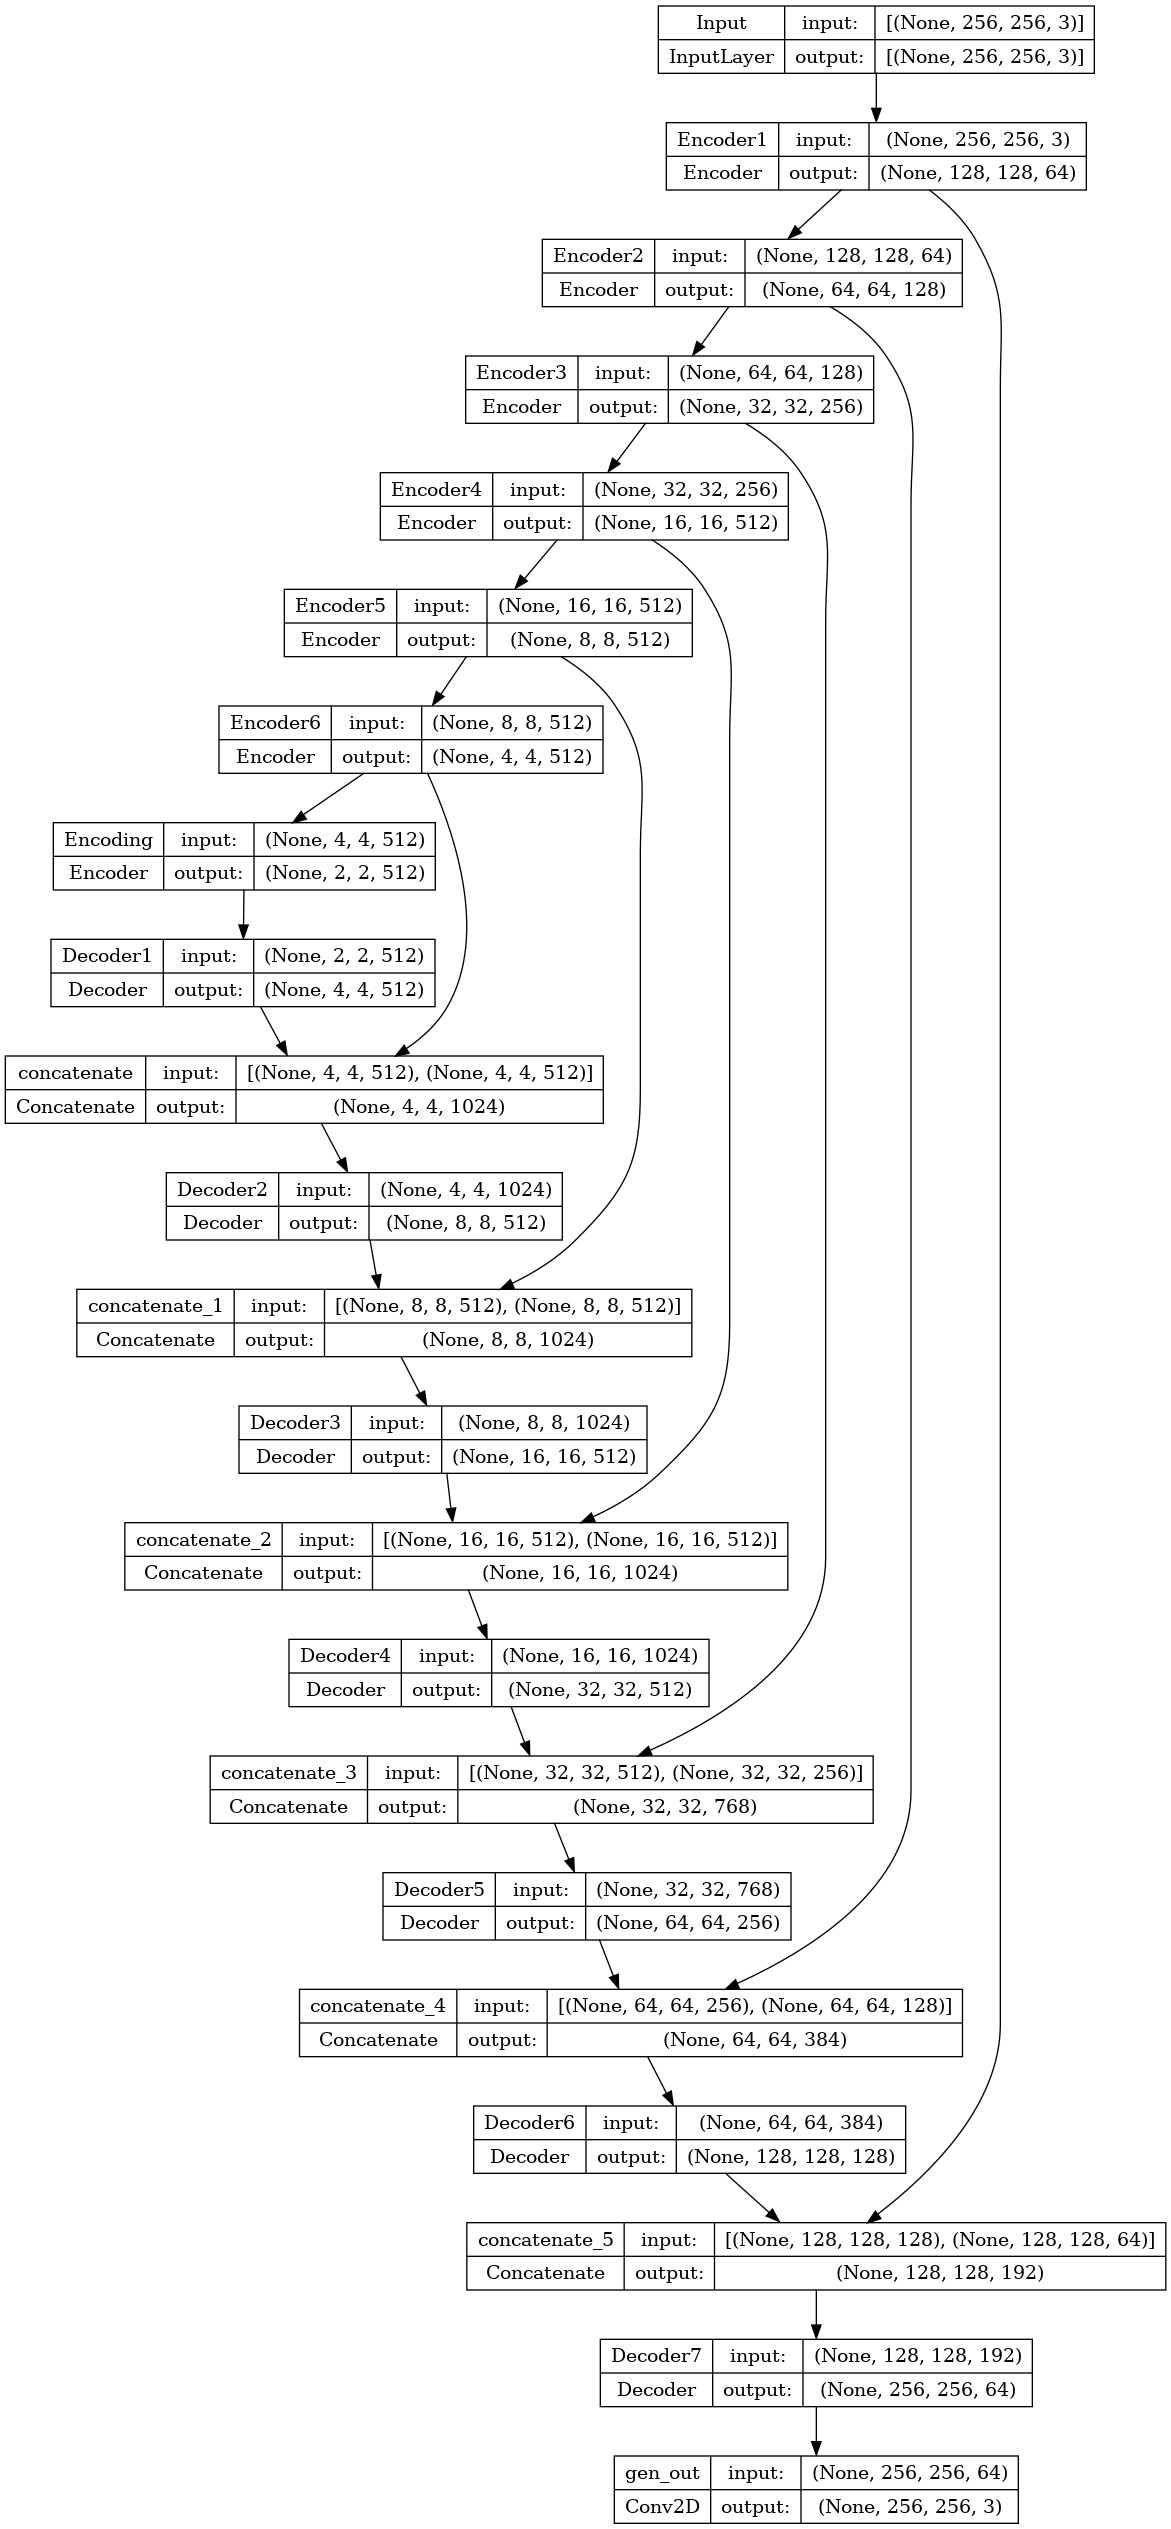

In [11]:


plot_model(generator, "Pix-2-Pix-Generator.png", show_shapes=True)



In [12]:


def show_predictions(model, n_images=5):
    for i in range(n_images):
        plt.figure(figsize=(10,8))
        
        id = randint(len(train_images))
        image, mask = train_images[id], train_masks[id]
        pred_mask = model.predict(image[np.newaxis,...])[0]
        
        plt.subplot(1,3,1)
        show_image(image, title='Original Image')
        
        plt.subplot(1,3,2)
        show_image(mask, title='Original Mask')
        
        plt.subplot(1,3,3)
        show_image(pred_mask, title='Predicted Mask')
        
        plt.show()



In [13]:


class ShowProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if ((epoch+1)%5==0):
            show_predictions(model=self.model, n_images=1)



1/1 [==============================] - 6s 6s/step


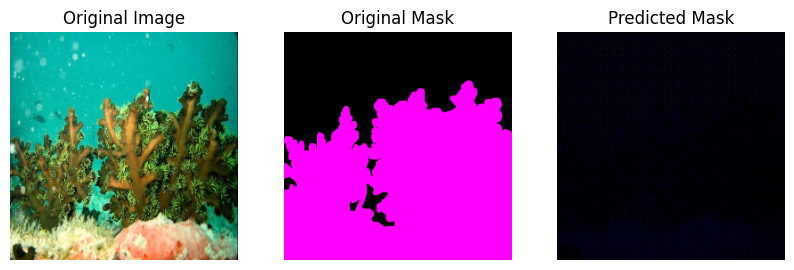

1/1 [==============================] - 0s 30ms/step


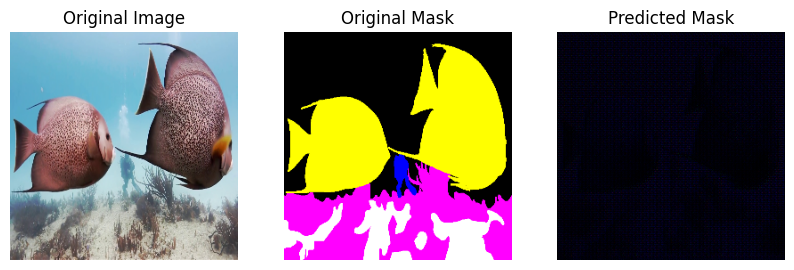

1/1 [==============================] - 0s 20ms/step


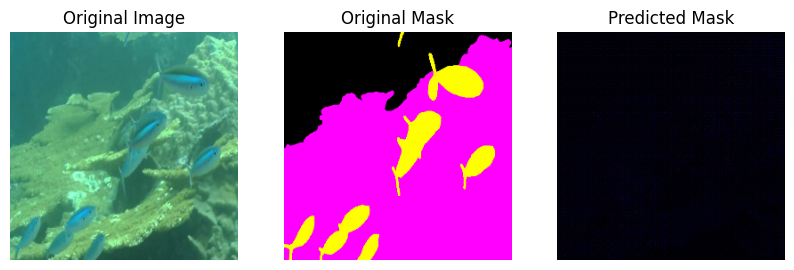

1/1 [==============================] - 0s 20ms/step


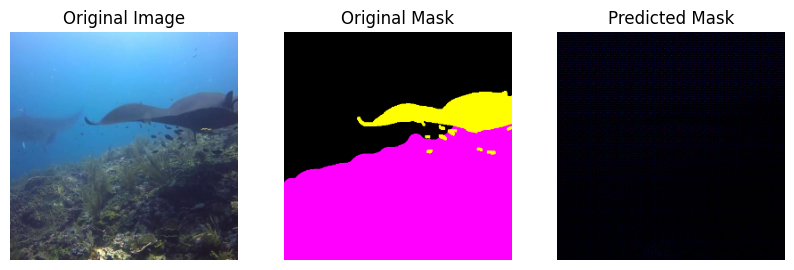

1/1 [==============================] - 0s 20ms/step


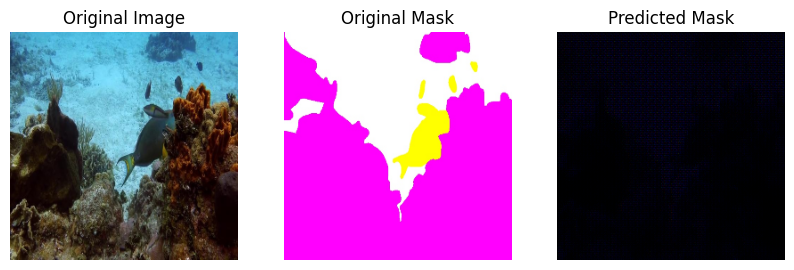

In [14]:
show_predictions(generator)

In [15]:
class ZeroPaddingBlock(Layer):
    
    def __init__(self, **kwargs):
        super(ZeroPaddingBlock, self).__init__(**kwargs)
        
        init = tf.random_normal_initializer(stddev=0.02)
        self.z1 = ZeroPadding2D()
        self.c = Conv2DTranspose(512, kernel_size=4, padding='valid', kernel_initializer=init, strides=1, use_bias=False)
        self.bn = BatchNormalization()
        self.act = LeakyReLU()
        self.z2 = ZeroPadding2D()
        
    def call(self, X):
        x = self.z1(X)
        x = self.c(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.z2(x)
        return x

In [16]:
# Kernel Initializer
init = tf.random_normal_initializer(stddev=0.02)

# Inputs 
src_img = Input(shape=(256,256,3), name="SourceImage")
gen_img = Input(shape=(256,256,3), name="GenImage")

# Join Inputs
x = concatenate([src_img, gen_img])

# Network
x = Encoder(64, apply_norm=False, name="Block1")(x)
x = Encoder(128, name="Block2")(x)
x = Encoder(256, name="Block3")(x)
x = Encoder(512, name="Block4")(x)
x = ZeroPaddingBlock(name="Block5")(x)
patch_out = Conv2D(1, kernel_size=4, strides=1, padding='valid', kernel_initializer=init)(x)

# Discriminator
discriminator = Model(
    inputs=[src_img, gen_img],
    outputs=[patch_out],
    name="Discriminator"
)

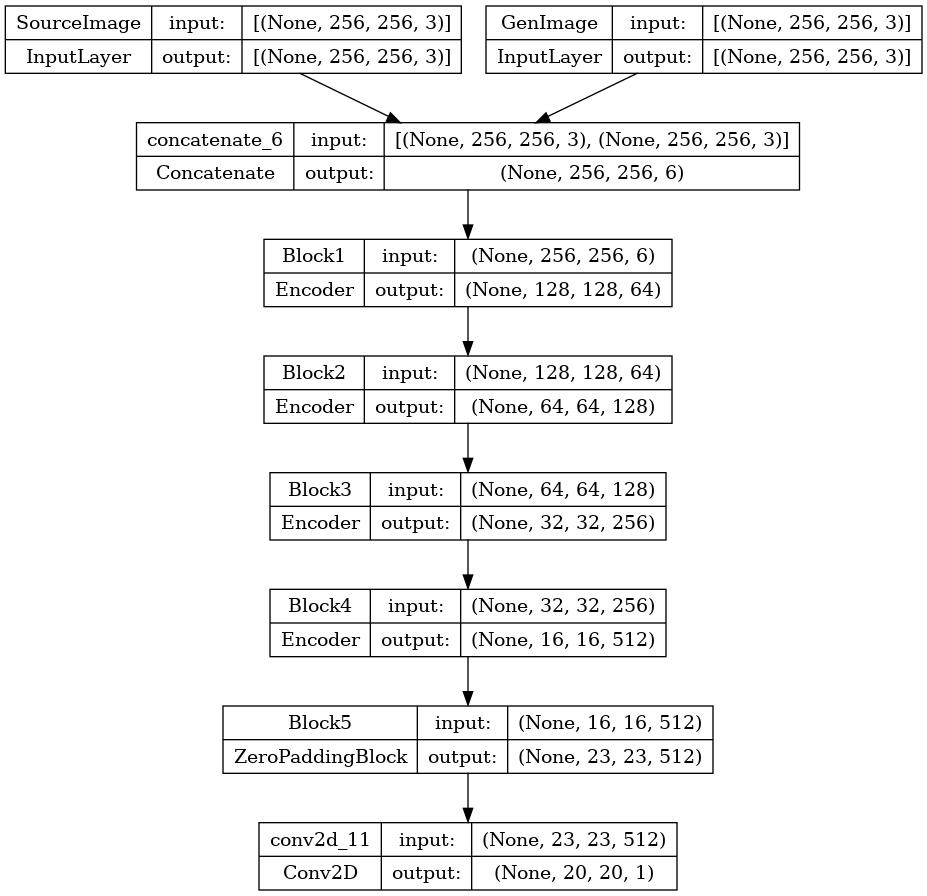

In [17]:
plot_model(discriminator, "Discriminator.png", show_shapes=True)

In [18]:
object_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def adveserial_loss(disc_fake, gen_out, true_output):
    gan_loss = object_fn(tf.ones_like(disc_fake), disc_fake)
    gen_loss = tf.reduce_mean(tf.abs(true_output - gen_out))
    total_loss = gan_loss + gen_loss
    return total_loss * 100

In [20]:


def discriminator_loss(disc_real, disc_fake):
    real_loss = object_fn(tf.ones_like(disc_real), disc_real)
    fake_loss = object_fn(tf.zeros_like(disc_fake), disc_fake)
    total_loss = real_loss + fake_loss
    return total_loss



In [21]:


gen_opt = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5) # TTUR
dis_opt = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)



In [22]:


@tf.function()
def train_step(images, masks):
    images, masks = tf.cast(images, tf.float32), tf.cast(masks, tf.float32)
    
    with tf.GradientTape(persistent=True) as tape:
        
        # Fake generation
        gen_out = generator(images, training=True)
        
        # Discriminator
        dis_real = discriminator([images, masks], training=True)
        dis_fake = discriminator([images, gen_out], training=True)
        
        # Calculate Losses
        gen_loss = adveserial_loss(dis_fake, gen_out, masks)
        disc_loss = discriminator_loss(dis_real, dis_fake)
        
    # Calculate Gradients
    gen_grads = tape.gradient(gen_loss, generator.trainable_variables)
    dis_grads = tape.gradient(disc_loss, discriminator.trainable_variables)    
    
    # Apply Gradients
    gen_opt.apply_gradients(zip(gen_grads, generator.trainable_variables))
    dis_opt.apply_gradients(zip(dis_grads, discriminator.trainable_variables))



In [23]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks)).shuffle(1000).batch(1)

In [24]:


def fit(epochs=100, chunk=5):
    for epoch in tqdm(range(epochs),desc="Epochs"):
        for images, masks in train_ds:
            train_step(images, masks)
        if (epoch+1)%chunk==0:
            generator.save("Pix2PixGenerator-UnderWaterImagery.h5")
            show_predictions(generator, n_images=2)



In [ ]:
fit() # Train

In [ ]:
show_predictions(generator, n_images=10)